In [1]:
import os
import sys
import yaml
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad

import data_utils


def run_umap(adata, labels, outdir=None):
    X = adata.X
    if not isinstance(X, np.ndarray):
        X = X.toarray()

    reducer = umap.UMAP(n_neighbors=40, n_components=2, metric="correlation", min_dist=0.3, random_state=42)
    embedding = reducer.fit_transform(X)
    print(f"UMAP shape: {embedding.shape}")

    unique_labels = np.unique(labels)
    n_labels = len(unique_labels)
    # Make a large enough color palette (tab20 has 20 colors, so combine several)
    base_cmaps = ['tab20', 'tab20b', 'tab20c']
    colors = []

    for cmap_name in base_cmaps:
        cmap = plt.cm.get_cmap(cmap_name)
        colors.extend([cmap(i) for i in range(cmap.N)])

    # Ensure we have at least n_labels colors
    colors = colors[:n_labels]

    # Map each label → one unique color
    color_map = {lab: colors[i] for i, lab in enumerate(unique_labels)}

    point_colors = [color_map[l] for l in labels]

    plt.figure(figsize=(7, 6))
    plt.scatter(embedding[:, 0],
                embedding[:, 1],
                c=point_colors, cmap="tab20", s=6)
    plt.title("UMAP Projection")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    if outdir is not None:
        os.makedirs(outdir, exist_ok=True)
        plt.savefig(os.path.join(outdir, "umap_clusters.png"), dpi=300)
    else:
        plt.show()
    plt.close()

/Users/veramazeeva/anaconda3/envs/bioinf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/veramazeeva/anaconda3/envs/bioinf/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
expr = "../../project/data/subset_expression_processed.h5ad"
meta = "../../project/data/subset_metadata_prop.csv"

In [8]:
adata = data_utils.load_hd5a(expr)
metadata = data_utils.load_metadata(meta, label_col='subclass_label')
n, labels = data_utils.get_sample_labels(metadata, label_col='subclass_label')

Loaded expression data: 5001 cells x 2000 genes
No. cell types: 42


In [23]:
print("====== RAW DATA STATS ======")
adata = data_utils.load_hd5a('/Users/veramazeeva/Library/CloudStorage/OneDrive-Personal/Columbia/UML/UML4774-Project/scRNA-Seq/scMSCF/data/input/subset_expression_prop.h5ad')

print(f"Cells (n_obs): {adata.n_obs}")
print(f"Genes (n_vars): {adata.n_vars}")

# Extract matrix
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X

print(f"Total expression (sum of all counts): {X.sum():.2f}")
print(f"Mean per cell: {X.sum(axis=1).mean():.2f}")
print(f"Median per cell: {np.median(X.sum(axis=1)):.2f}")
print(f"Mean per gene: {X.sum(axis=0).mean():.2f}")

# Sparsity
nonzero = np.count_nonzero(X)
total = X.size
print(f"Sparsity: {100 * (1 - nonzero/total):.2f}% (fraction of zeros)")

# Per-gene stats
gene_means = X.mean(axis=0)
print(f"Top expressed genes (mean): {np.sort(gene_means)[-5:]}")

# Per-cell stats
cell_means = X.mean(axis=1)
print(f"Top expressed cells (mean): {np.sort(cell_means)[-5:]}")

# === Count zeros per row ===
zeros_per_row = (X == 0).sum(axis=1)

print("====== ZERO COUNTS PER CELL ======")
print(f"Mean zeros per cell: {zeros_per_row.mean():.2f}")
print(f"Median zeros per cell: {np.median(zeros_per_row):.2f}")
print(f"Min zeros in a cell: {zeros_per_row.min()}")
print(f"Max zeros in a cell: {zeros_per_row.max()}")



====== RAW DATA STATS ======
Loaded expression data: 5001 cells x 31053 genes
Cells (n_obs): 5001
Genes (n_vars): 31053
Total expression (sum of all counts): 58711448.00
Mean per cell: 11739.94
Median per cell: 10699.00
Mean per gene: 1890.69
Sparsity: 86.66% (fraction of zeros)
Top expressed genes (mean): [ 57.256348  60.812637  74.171165  97.90642  278.4609  ]
Top expressed cells (mean): [1.2120246 1.2222329 1.287605  1.349789  1.4939297]
====== ZERO COUNTS PER CELL ======
Mean zeros per cell: 26911.67
Median zeros per cell: 26902.00
Min zeros in a cell: 23463
Max zeros in a cell: 30043
Example (first 10 cells):
[24418 29011 25876 24549 25776 26513 27838 25468 26425 26548]


In [20]:
adata.obs["total_counts"] = X.sum(axis=1)
adata.obs["n_genes_nonzero"] = (X != 0).sum(axis=1)

print("\n===== QUALITY CONTROL SUMMARY =====")
print(adata.obs[["total_counts", "n_genes_nonzero"]].describe())



===== QUALITY CONTROL SUMMARY =====
       total_counts  n_genes_nonzero
count   5001.000000           5001.0
mean     -16.250010           2000.0
std      146.557999              0.0
min     -294.902405           2000.0
25%     -101.090637           2000.0
50%      -39.688873           2000.0
75%       40.091019           2000.0
max     1248.690552           2000.0


In [39]:
labels

,sample_name,class_label
0,CCACTACTCTGTTTGT-L8TX_190312_01_E01,Glutamatergic
1,GTTACAGGTTCAGGCC-L8TX_171026_01_B05,Glutamatergic
2,TCAGCAAAGAGCAATT-L8TX_190312_01_C01,Glutamatergic
3,GTTCATTAGGGCTTGA-L8TX_180115_01_A10,Glutamatergic
4,GATTCAGCAGATCGGA-L8TX_180221_01_D10,Glutamatergic
...,...,...
4996,AGAGTGGAGCTCCCAG-L8TX_180406_01_B07,Glutamatergic
4997,GCTTGAATCTGACCTC-L8TX_180907_01_F11,Non-Neuronal
4998,CGCCAAGAGTGCCATT-L8TX_180221_01_H10,Glutamatergic
4999,GGCTGGTCACTAGTAC-L8TX_180926_01_C12,Non-Neuronal


In [7]:
adata.obs_names

Index(['CCACTACTCTGTTTGT-L8TX_190312_01_E01',
       'GTTACAGGTTCAGGCC-L8TX_171026_01_B05',
       'TCAGCAAAGAGCAATT-L8TX_190312_01_C01',
       'GTTCATTAGGGCTTGA-L8TX_180115_01_A10',
       'GATTCAGCAGATCGGA-L8TX_180221_01_D10',
       'TAGTTGGCAATGGTCT-L8TX_180115_01_E10',
       'TACTTACTCCACGTTC-L8TX_181012_01_G04',
       'CGGCTAGTCCGCATCT-L8TX_180115_01_B11',
       'AACTGGTCAACACGCC-L8TX_190312_01_A02',
       'GGGATGACACCGCTAG-L8TX_180712_01_G05',
       ...
       'TACTTGTGTTACGACT-L8TX_190312_01_C01',
       'CGATGTAAGCGATTCT-L8TX_200625_02_F11',
       'CAGCTGGAGACAAAGG-L8TX_200625_02_F11',
       'CTCTAATGTTTGCATG-L8TX_200625_02_E11',
       'CACAGTAAGTGTCTCA-L8TX_190312_01_A02',
       'AGAGTGGAGCTCCCAG-L8TX_180406_01_B07',
       'GCTTGAATCTGACCTC-L8TX_180907_01_F11',
       'CGCCAAGAGTGCCATT-L8TX_180221_01_H10',
       'GGCTGGTCACTAGTAC-L8TX_180926_01_C12',
       'CAACCTCTCCCTTGCA-L8TX_180115_01_E08'],
      dtype='object', name='sample_name', length=5001)

/Users/veramazeeva/anaconda3/envs/bioinf/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (5001, 2)


/var/folders/gb/6nj_ltrj4xz37dn5k89d40n00000gn/T/ipykernel_9427/1663285719.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)
/var/folders/gb/6nj_ltrj4xz37dn5k89d40n00000gn/T/ipykernel_9427/1663285719.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0],


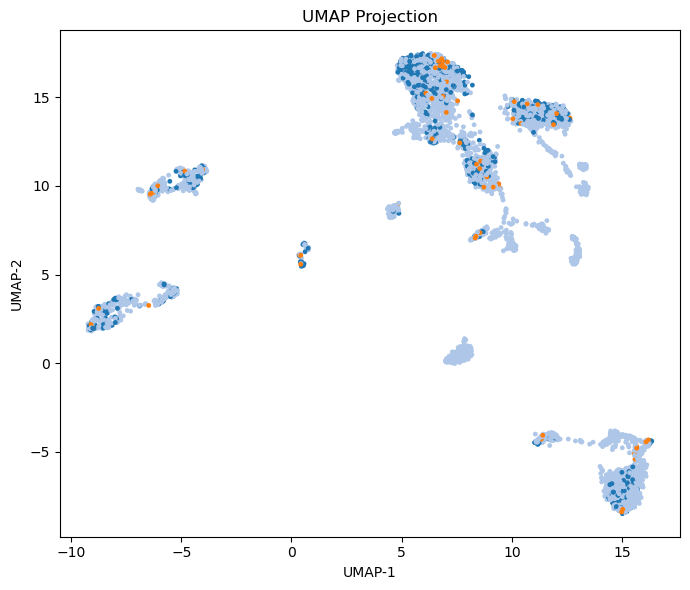

In [4]:
run_umap(adata, labels['class_label'])

/Users/veramazeeva/anaconda3/envs/bioinf/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (5001, 2)


/var/folders/gb/6nj_ltrj4xz37dn5k89d40n00000gn/T/ipykernel_9427/1663285719.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)
/var/folders/gb/6nj_ltrj4xz37dn5k89d40n00000gn/T/ipykernel_9427/1663285719.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0],


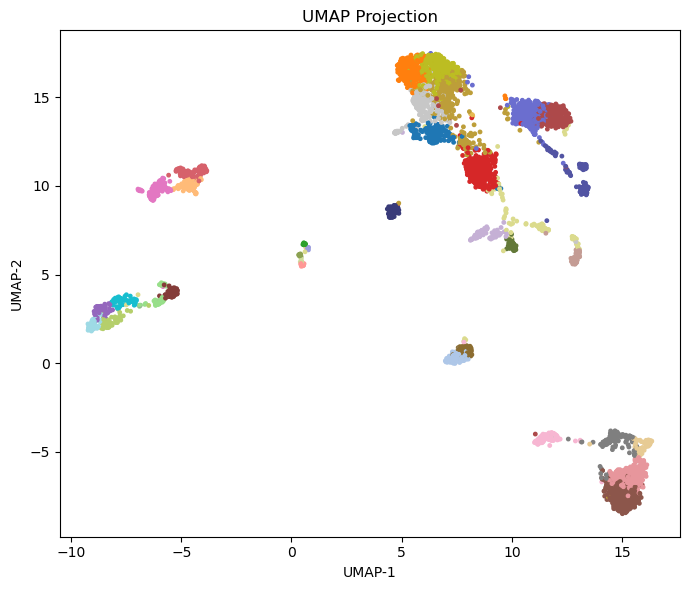

In [5]:
labels_file = '/Users/veramazeeva/Library/CloudStorage/OneDrive-Personal/Columbia/UML/UML4774-Project/scRNA-Seq/scMSCF/data/predicted_cluster.csv'
labels = pd.read_csv(labels_file)
run_umap(adata, labels['Predicted_Cluster'])

In [42]:
top_cf = pd.read_csv('scMSCF/data/top_confidence_cells.csv')

In [43]:
set(top_cf['final_cluster'].to_list())

{1, 2, 4, 5, 6, 8, 9, 10, 13, 17}

In [29]:
len(top_cf), len(labels)

(4001, 5001)

In [46]:
set(labels['final_cluster'].to_list())

{1, 2, 4, 5, 6, 8, 9, 10, 13, 17}

In [6]:
final_clusters = pd.read_csv('scMSCF/data/predicted_cluster.csv')

In [48]:
set(final_clusters['Predicted_Cluster'].to_list())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

/Users/veramazeeva/anaconda3/envs/bioinf/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (5001, 2)


/var/folders/gb/6nj_ltrj4xz37dn5k89d40n00000gn/T/ipykernel_86731/1663285719.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)
/var/folders/gb/6nj_ltrj4xz37dn5k89d40n00000gn/T/ipykernel_86731/1663285719.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0],


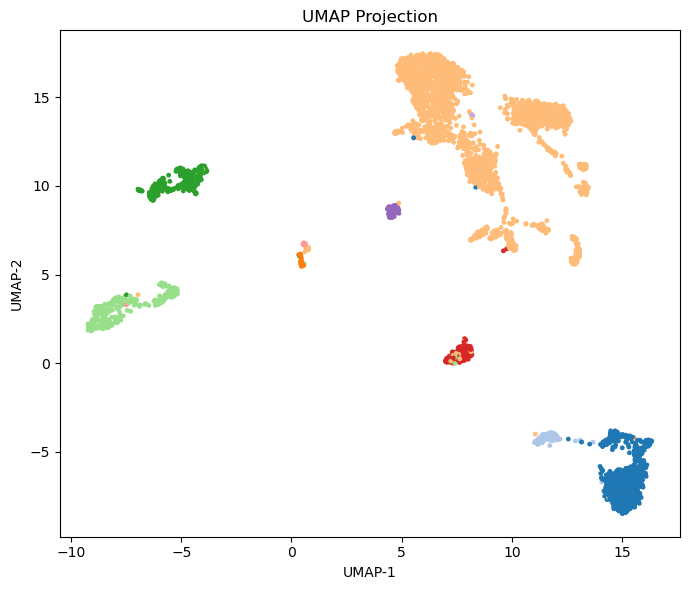

In [49]:
run_umap(adata, final_clusters['Predicted_Cluster'])

In [13]:
metadata = data_utils.load_metadata(meta, label_col='subclass_label')
n, labels_ = data_utils.get_sample_labels(metadata, label_col='subclass_label')

No. cell types: 42


In [15]:
labels_file = '/Users/veramazeeva/Library/CloudStorage/OneDrive-Personal/Columbia/UML/UML4774-Project/scRNA-Seq/scMSCF/data/kmeans_pca.csv'
labels = pd.read_csv(labels_file)

In [16]:
labels

,sample_name,pca30_kmeans38,pca30_kmeans39,pca35_kmeans22,pca35_kmeans23,pca40_kmeans38,pca40_kmeans39,pca45_kmeans31,pca45_kmeans32,pca50_kmeans35,pca50_kmeans36
0,CCACTACTCTGTTTGT-L8TX_190312_01_E01,32,14,20,17,18,0,26,18,8,22
1,GTTACAGGTTCAGGCC-L8TX_171026_01_B05,12,34,20,17,18,0,26,18,8,22
2,TCAGCAAAGAGCAATT-L8TX_190312_01_C01,9,7,3,9,5,1,18,12,5,34
3,GTTCATTAGGGCTTGA-L8TX_180115_01_A10,36,29,0,1,30,17,2,24,1,0
4,GATTCAGCAGATCGGA-L8TX_180221_01_D10,16,27,8,1,31,33,1,2,26,9
...,...,...,...,...,...,...,...,...,...,...,...
4996,AGAGTGGAGCTCCCAG-L8TX_180406_01_B07,30,26,7,13,13,9,27,17,14,29
4997,GCTTGAATCTGACCTC-L8TX_180907_01_F11,16,27,8,1,31,33,1,2,26,9
4998,CGCCAAGAGTGCCATT-L8TX_180221_01_H10,16,27,8,1,31,33,1,2,26,9
4999,GGCTGGTCACTAGTAC-L8TX_180926_01_C12,16,27,0,1,31,33,1,2,26,9


In [12]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(labels['final_cluster'], final_clusters['Predicted_Cluster'])
nmi = normalized_mutual_info_score(labels['final_cluster'], final_clusters['Predicted_Cluster'])
print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}")

ARI: 0.1484, NMI: 0.5967


In [18]:
ari = adjusted_rand_score(labels['pca50_kmeans36'], labels_['subclass_label'])
nmi = normalized_mutual_info_score(labels['pca50_kmeans36'], labels_['subclass_label'])
print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}")

ARI: 0.0361, NMI: 0.1697
